# Predicting quantity of users using shared bikes

## Introduction

**Bike sharing is a recent trend that spread fast around the world.  It has a control system that gives an user a bike access for a determined time slot. The user get the bike and return to the same spot within the time slot. There are many advantages to go by bike, not only for reducing the traffick and poluition but also to get a healthier population. To the companies, it is indispensible to understand the users behaviour and manage their bikes to be always avaliable.** 


![title](img/why-you-use-ride-sharing-bike-service.jpg)


## Businnes problem: 
### Predict the number of bike rental per day based on the environmental and seasonal data
----------------------------------------------------------------------------------------------------

## Understanding the dataset

**This dataset was kindly shared by Hadi Fanaee-T from 
Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Port**

**It was sampled both by day and by hour (file1 and file2**

- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual and registered: - both removed from the dataset because the sum is the total of counts
	- cnt: count of total rental bikes including both casual and registered

**Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import Normalizer, OrdinalEncoder
import itertools as it
from tqdm import tqdm
import seaborn as sns
import datetime as dt
import math
import torch

%matplotlib inline

In [2]:
file1 = '/mnt/c/Users/Cafalchio/Documents/Bike-Sharing-Dataset/bikes_day.csv'
# file1 it was the same data but sampled daily
file2= '/mnt/c/Users/Cafalchio/Documents/Bike-Sharing-Dataset/hour.csv'
# file2 was sampled by hour

In [3]:
class Data:
    ''' Class to open and explore the dataset and create a baseline model'''
    def __init__(self, file, target='cnt'):
        try:
            self.df = pd.read_csv(file)
        except:
            print('Could not read CSV file')
        self.df['date'] = pd.to_datetime(self.df['dteday'])
        self.df['date'] = self.df['date'].map(dt.datetime.toordinal)
        self.df['date'] = (self.df['date']-self.df.date.min())/(self.df.date.max()-self.df.date.min())
        self.df.drop(['dteday', 'instant'], axis=1, inplace=True)
        self.target = target
    
#     def change_category(self):
#         ''' Method used to change features to categorical
#             it had no effect on the analysis and was commented
#         '''
#         c = self.df.select_dtypes(np.integer).columns
#         self.df[c] = self.df[c].astype('category')
    
    def drop(self, col):
        ''' Class that drop the column col from the dataframe''' 
        self.df.drop(col, axis=1, inplace=True)
    
    def plot_correlation(self):
        ''' PLot the correlation matrix from of the dataframe'''
        corrMatrix = self.df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corrMatrix, annot=False,  linewidths=1)
        plt.show()
        
    def summary(self, n=5):
        ''' A Formated summary of the dataframe'''
        
        print('-------------- Information about the data ---------------------\n')
        print(self.df.info())
        print('\n----------------------- Data types ----------------------------\n')
        print(self.df.dtypes)
        print('\n--------------------- Data describe ---------------------------\n')
        print(self.df.describe())
        print('\n----------------------- Data head -----------------------------\n')
        return(self.df.head())
    
    def split_data(self, size=.33):
        ''' Method that splits the data into train and validation
        Input: the size of the validation data
        Output: X_train, X_val, y_train, y_val (numpy values)
        '''
        y = self.df[self.target]
        X = self.df.drop(self.target, axis=1)
        return train_test_split(X.values, y.values, test_size=.25, random_state=42)
    
    def get_baseline_linear(self):
        '''Runs linear models with all combinations of columns and print best 3 combinations
        Input: data, target, test_size
        Output: Columns and r^2 of the best model
        '''
        temp = []
        col = []
        scores = []
        y = self.df[self.target]
        columns = self.df.drop(self.target, axis=1).columns
        for i in tqdm(range(1, len(columns)-1)):
            for x in it.combinations(columns, i):
                X = self.df[list(x)]
                col.append(x)
                ##Run the model
                X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=.25, random_state=42)
                model = LinearRegression().fit(X_train, y_train)
                y_true = model.predict(X_test)
                res = r2_score(y_true, y_test)
                ##Save scores
                scores.append(res)
        ## print 3 best combinations
        for key, value in zip(col, scores):
            if value in sorted(scores)[-1:]:
                print(f'{key} \t {value:.7f}:\n')  
                
    def embbeded_time(self):
        ''' Was used to transform the dteday but had no effect on the model
        and was commented'''
        self.df.date = self.df.date-self.df.date.min()

In [4]:
data = Data(file1)

In [5]:
data.summary()

-------------- Information about the data ---------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  cnt         731 non-null    int64  
 12  date        731 non-null    float64
dtypes: float64(5), int64(8)
memory usage: 74.4 KB
None

----------------------- Data types ----------------------------

season          int64
yr              int64
mnth            int64
holiday         int64
weekd

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0.000000
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0.042466
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0.080822
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0.123288
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0.164384


**There is no missing values in the data , which is great. The dteday have been already being divided into weekdays, workinday, season, year and month. Which has much more information than the date itself. For this reason, the dteday will be removed. But before that, lets have a look into the cross-correlation matrix.**

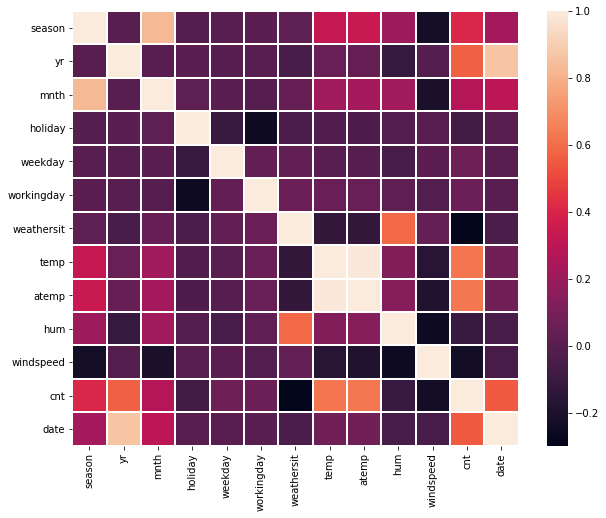

In [6]:
data.plot_correlation()

**In the first version of the code, I was removing columns that were high correlated with others and testing the model, however, it was hard to decide what columns to keep or remove.**

**To solve this problem, a method called get_baseline_linear() was created to keep repeating the regression with all combinations of columns to test the best combination.**


In [7]:
data.get_baseline_linear()

100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


('season', 'yr', 'mnth', 'holiday', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed', 'date') 	 0.8048849:



**This result was much better than 0.77 that I got by selecting the columns manually**

**It is interesting to see that temperature gives a little better result than temperature feeling in my first model I have removed the temperature and kept the feeling.**


## Repeating the analysis for the file2 by hour

In [8]:
data = Data(file2)

In [9]:
data.get_baseline_linear()

100%|██████████| 11/11 [00:32<00:00,  3.00s/it]


('season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'date') 	 -0.5754012:



### Ops! Seems that a simple regression is not enough to approximate this data. A more complex linear model can be used to approximated the data.

In [10]:
#Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

**Load file**

In [12]:
#Load file 2
data = Data(file2) 
#Split the data into train and validation as before
X_train, X_test, y_train, y_test = data.split_data()

**Create Dataset class**

In [13]:
class RegressionData(Dataset):
    ''' A class to return X and y to be used as Dataset to the pytorch dataloader'''
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

**Create dataloader, responsible to load data in batches**

In [14]:
train_dataset = RegressionData(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionData(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

**Variables defined to improve the model output**

In [23]:
# Values empirically decided to get the best regression model
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 0.003
NUM_FEATURES = X_train.shape[1]

**Instantiate dataloaders**

In [24]:
# Create train and val data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

**Create the regression model**

In [25]:
class Regression(nn.Module):
    ''' Linear model created with:
    input layer, layer2, layer3 and output layer all using Relu
    as activation function.'''
    def __init__(self, num_features):
        super(Regression, self).__init__()
        self.layer_1 = nn.Linear(num_features, 512)
        self.layer_2 = nn.Linear(512, 1024)
        self.layer_3 = nn.Linear(1024, 512)
        self.layer_out = nn.Linear(512, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

In [26]:
# Check shape of the data
for i, (inputs, targets) in enumerate(train_loader):
    print(f'{inputs.shape}\t{targets.shape}')
    break

torch.Size([256, 13])	torch.Size([256])


In [27]:
# Use torch on the CPU
device = torch.device("cpu")

**Create the model**

In [28]:
#Create model
model = Regression(NUM_FEATURES)

**Function that train and validate the model**

This function loads data batch by batch and train the model, after training, gets the loss and update the weigths based on the learning rate. It also performs validation and calculates the metric (r2) so we can compare with the scikit-learn regression

In [29]:
def train_model(EPOCHS, LEARNING_RATE):
    ''' Function to train the model:
    Inputs: EPOCHS: number of epochs to be trained
    and LEARNING_RATE the learning rate of the model.
    Outputs: Losses dict and r2 metric
    '''
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    metric = 0
    loss_stats = {
        'train': [],
        "val": []
    }
    for epoch in range(0, EPOCHS):
        train_epoch_loss = 0
        metric = []
        model.train()
        #Training
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = nn.MSELoss()
            train_loss = loss(y_pred, y_train.unsqueeze(1))
            train_loss.backward()
            optimizer.step()
            train_epoch_loss += train_loss.item()
            
            # Validation
            with torch.no_grad():
                val_epoch_loss = 0
                model.eval()
                for X_test, y_test in val_loader:
                    X_test, y_test = X_test.to(device), y_test.to(device) 
                    y_test_pred = model(X_test)
                    val_loss = torch.nn.MSELoss()(y_test_pred, y_test.unsqueeze(1))
                    metric.append(r2_score(y_pred.detach(), y_train.unsqueeze(1).detach()))
                    val_epoch_loss += val_loss.item()
                    
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader)) 
        
        if (epoch%int(EPOCHS/10))==0:
            print(f'Epoch {epoch}: | Train Loss: {train_epoch_loss/len(train_loader):.2f} | Val Loss: {val_epoch_loss/len(val_loader):.2f}')
            print(f'r2_val:{sum(metric)/len(metric):.2f}')
    return loss_stats, metric

**Training the model**

In [30]:
stats, r2 = train_model(EPOCHS, LEARNING_RATE)

Epoch 0: | Train Loss: 29344.91 | Val Loss: 20700.46
r2_val:-126933.37
Epoch 6: | Train Loss: 11782.91 | Val Loss: 11244.74
r2_val:0.43
Epoch 12: | Train Loss: 8013.67 | Val Loss: 7320.41
r2_val:0.67
Epoch 18: | Train Loss: 6041.31 | Val Loss: 5610.41
r2_val:0.77
Epoch 24: | Train Loss: 4681.76 | Val Loss: 4250.42
r2_val:0.83
Epoch 30: | Train Loss: 4016.22 | Val Loss: 4123.99
r2_val:0.86
Epoch 36: | Train Loss: 3375.17 | Val Loss: 3621.80
r2_val:0.88
Epoch 42: | Train Loss: 3185.61 | Val Loss: 2814.35
r2_val:0.89
Epoch 48: | Train Loss: 2309.67 | Val Loss: 2622.55
r2_val:0.92
Epoch 54: | Train Loss: 2181.13 | Val Loss: 2748.81
r2_val:0.93


In [37]:
def plot_val(stats, lr=LEARNING_RATE):
    plt.plot(stats['train'], label='train')
    plt.plot(stats['val'], label='validation')
    plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.95))
    plt.ylabel('MSE loss')
    plt.xlabel('Number of epochs')
    plt.title(f'Regression model (lr={lr})')
    plt.show()
    return None

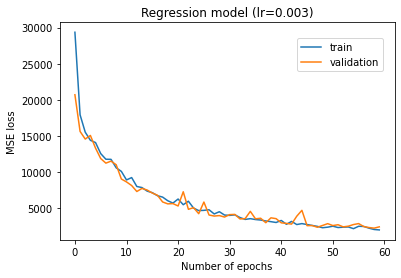

In [38]:
plot_val(stats, LEARNING_RATE)

### This is a impressive result compared to the scikit-learn regression.


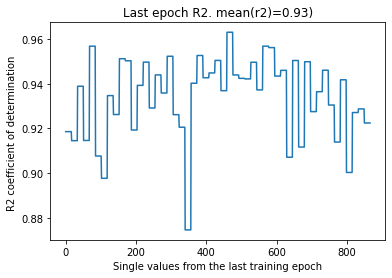

In [44]:
plt.plot(r2)
plt.ylabel('R2 coefficient of determination ')
plt.xlabel('Single values from the last training epoch')
plt.title(f'Last epoch R2. mean(r2)={sum(r2)/len(r2):.2f})')
plt.show()

**During the last training epoch the R2 scorevaried from .88 to .96** 

# Finally let's try this model to the first dataset (dailly)

**All the classes and fucntions can be reused**

In [47]:
#Load file 1
data = Data(file1) 
#Split the data into train and validation as before
X_train, X_test, y_train, y_test = data.split_data()

train_dataset = RegressionData(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionData(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
# Create a new model
model = Regression(NUM_FEATURES)

**Lets start with the same values for epochs, batch size and learning rate**

In [49]:
# Values empirically decided to get the best regression model
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 0.003
NUM_FEATURES = X_train.shape[1]

**Train the model**

In [50]:
stats, r2 = train_model(EPOCHS, LEARNING_RATE)

Epoch 0: | Train Loss: 28325.68 | Val Loss: 20709.53
r2_val:-1384531.03
Epoch 3: | Train Loss: 14422.14 | Val Loss: 13014.32
r2_val:0.19
Epoch 6: | Train Loss: 11929.36 | Val Loss: 10759.15
r2_val:0.39
Epoch 9: | Train Loss: 9663.91 | Val Loss: 9612.56
r2_val:0.56
Epoch 12: | Train Loss: 7335.46 | Val Loss: 7820.73
r2_val:0.69
Epoch 15: | Train Loss: 6629.46 | Val Loss: 7317.23
r2_val:0.73
Epoch 18: | Train Loss: 5712.82 | Val Loss: 6078.24
r2_val:0.78
Epoch 21: | Train Loss: 4610.89 | Val Loss: 4551.20
r2_val:0.83
Epoch 24: | Train Loss: 4108.96 | Val Loss: 4198.95
r2_val:0.85
Epoch 27: | Train Loss: 3790.12 | Val Loss: 3816.19
r2_val:0.87


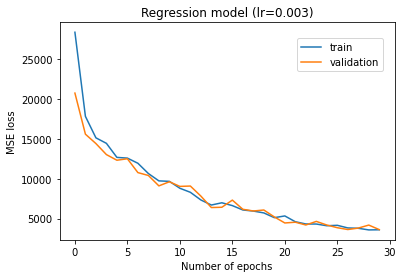

In [51]:
plot_val(stats, LEARNING_RATE)

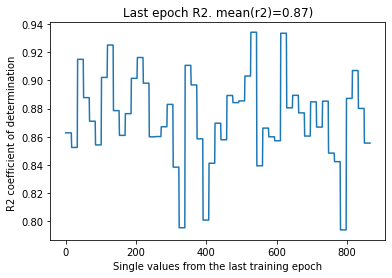

In [52]:
plt.plot(r2)
plt.ylabel('R2 coefficient of determination ')
plt.xlabel('Single values from the last training epoch')
plt.title(f'Last epoch R2. mean(r2)={sum(r2)/len(r2):.2f})')
plt.show()

# Conclusion:

### Simple regression was great for the simpler dataset but got quite far from the true in the same dataset but expanded by hours instead of days. The use of a more complex model helped to get better results on both datasets. However, the difference was enourmous on the more complex dataset.  The final conclusion is that the amount of bikes rented per day can be predicted with a good aproximation by using more complex linear models.